# Regression using Cyclic Boosting

First, install the  package and its dependencies

```sh
!pip install cyclic-boosting
```

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Let's use the test dataset from kaggle

Sign in to Kaggle at the URL below and download the dataset.  
https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset

Place the downloaded dataset in the following directory.  
examples/regression/tornado/time_series_bike_demand_forecasting/data/

For time-series data, a "date" column must be included to indicate the date and time the data was obtained. The column name and format must be consistent. The "dayofweek" column for the day of the week and the "dayofyear" column for the total number of days in the year are automatically created if not already present, but if they are already present, the column names must be correct.

This dataset has hourly data. In this dataset, the "instant" column is the data number. The "casual" and "registered" columns are the breakdown of sales, so they should be deleted.

In [2]:
parpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
df = pd.read_csv(parpath + "/time_series_bike_demand_forecasting/data/hour.csv")
df = df.rename(columns={'dteday': 'date', 'weekday': 'dayofweek'})
df = df.drop(columns=['instant', 'casual', 'registered'])
df["date"] = pd.to_datetime(df["date"])

df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)
df_train.to_csv("./bike_sharing_hour_train.csv", index=False)

In [3]:
df_train.head()

,date,season,yr,mnth,hr,holiday,dayofweek,workingday,weathersit,temp,atemp,hum,windspeed,cnt
8685,2012-01-02,1,1,1,17,1,1,0,1,0.26,0.2273,0.35,0.3881,153
12661,2012-06-16,2,1,6,18,0,6,0,2,0.72,0.6515,0.37,0.2239,571
1523,2011-03-08,1,0,3,20,0,2,1,1,0.32,0.3333,0.39,0.0896,76
16737,2012-12-05,4,1,12,4,0,3,1,1,0.50,0.4848,0.63,0.4478,10
15026,2012-09-23,4,1,9,7,0,0,0,1,0.46,0.4545,0.59,0.2239,57


# Automated Machine Learning with Tornado
With tornado, you can automatically perform data preparation, feature property setting, hyperparameter tuning, model building, training, evaluation, and plotting! (but, It might take a few minutes. Have a coffee break during execution.)

In [4]:
from cyclic_boosting.tornado import Generator, Manager, Tornado

data_deliverler = Generator.TornadoDataModule("./bike_sharing_hour_train.csv")
manager = Manager.TornadoModule()
predictor = Tornado.Tornado(data_deliverler, manager)
predictor.fit(target="cnt", log_policy="COD", verbose=False)

n_features: 13 -> 16 -> 10
['yr', 'hr', 'holiday', 'dayofweek', 'workingday', 'weathersit', 'temp', 'windspeed', 'dayofyear', 'date', 'cnt']
Auto analysis target ['temp', 'windspeed']Data interval is 'daily'. If not, give
    the data_interval option in the TornadoDataModule.
    is_unordered: ['yr', 'hr', 'holiday', 'dayofweek', 'workingday', 'weathersit', 'dayofyear']
    is_continuous: ['temp', 'windspeed']
    has_trend: ['temp', 'windspeed']
    has_seasonality: ['temp', 'windspeed']
    has_up_monotonicity: []
    has_down_monotonicity: []
    has_linearity: []
    has_missing: []
iter: 36 / 36 /mnt/c/Users/4074684/OneDrive - Panasonic/Microsoft Teams Data/Projects/15_Demand_forecasting/04_OSS_Project/01_Dev/workspace/rPrivate-cyclic-boosting/cyclic_boosting/plots/__init__.py:198: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To

Tornado model is able to point estimation and probability estimation.

8.551333846738098


<Axes: >

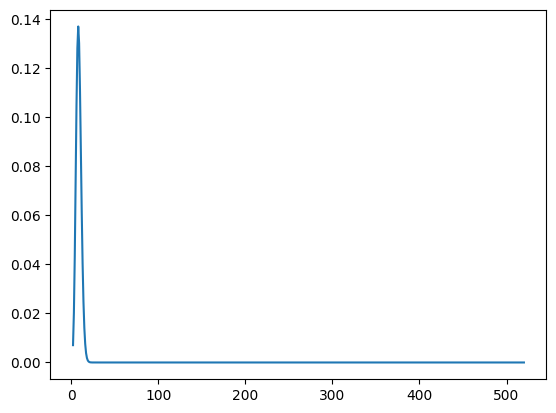

In [5]:
# mean point estimation
yhat = predictor.predict(df_test)
print(yhat[0])

# probability estimation with poisson distribution
proba = predictor.predict_proba(df_test.head(5), output="pmf")
proba.iloc[0, :].plot()

# Accuracy comparison with plain Cyclic boosting

Get the best model path.

In [6]:
from pathlib import Path

model_nos = []
for p in sorted(Path("./models/").glob("model*")):
    model_nos.append(str(p)[str(p).find("_") + 1 :])
model_path = f"./models/model_{model_nos[-1]}/model_{model_nos[-1]}.pkl"
print(model_path)

./models/model_42/model_42.pkl


Tornado can take care of setting the feature properties and interaction terms to obtain a better cyclic boosting model. However, be careful not to over-fitting when the amount of data is small.

In [24]:
from cyclic_boosting import flags, common_smoothers, observers
from cyclic_boosting.pipelines import pipeline_CBPoissonRegressor
from cyclic_boosting.smoothing.onedim import SeasonalSmoother
from sklearn.model_selection import train_test_split


df_train["dayofyear"] = df_train["date"].dt.dayofyear
df_test["dayofyear"] = df_test["date"].dt.dayofyear
train, _ = train_test_split(df_train, test_size=0.2, random_state=0)
y_train = np.asarray(train["cnt"])
X_train = train.drop(columns="cnt")
y_val = np.asarray(df_test["cnt"])
X_val = df_test.drop(columns="cnt")
if not all(np.asarray(train['cnt']) == manager.y):
    raise ValueError("Accuracy comparison is not available because\n"
                     "the data split is not the same as that of tornado.")


feature_properties = {
    "season": flags.IS_UNORDERED,
    "dayofweek": flags.IS_ORDERED,
    "dayofyear": flags.IS_CONTINUOUS | flags.IS_LINEAR,
    "yr": flags.IS_ORDERED,
    "mnth": flags.IS_ORDERED,
    "hr": flags.IS_ORDERED,
    "holiday": flags.IS_UNORDERED,
    "workingday": flags.IS_UNORDERED,
    "weathersit": flags.IS_UNORDERED,
    "temp": flags.IS_CONTINUOUS,
    "atemp": flags.IS_CONTINUOUS,
    "hum": flags.IS_CONTINUOUS,
    "windspeed": flags.IS_CONTINUOUS,
}

features = [
    "season",
    "dayofweek",
    "dayofyear",
    "yr",
    "mnth",
    "hr",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
]

explicit_smoothers = {
    ("dayofyear",): SeasonalSmoother(order=3),
}

plobs = [
    observers.PlottingObserver(iteration=1),
    observers.PlottingObserver(iteration=-1),
]

CB_est = pipeline_CBPoissonRegressor(
    feature_properties=feature_properties,
    feature_groups=features,
    observers=plobs,
    maximal_iterations=50,
    smoother_choice=common_smoothers.SmootherChoiceGroupBy(
        use_regression_type=True,
        use_normalization=False,
        explicit_smoothers=explicit_smoothers,
    ),
)

_ = CB_est.fit(X_train.copy(), y_train)

yhat = predictor.predict(df_test)
mse_tornado = np.nanmean(np.square(y_val - yhat))
mae_tornado = np.nanmean(np.abs(y_val - yhat))
wmape_tornado = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val)

yhat = CB_est.predict(X_val.copy())
mse = np.nanmean(np.square(y_val - yhat))
mae = np.nanmean(np.abs(y_val - yhat))
wmape = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val)

pd.options.display.float_format = '{:.2f}'.format
val_results = pd.DataFrame([[np.sqrt(mse_tornado), mae_tornado, wmape_tornado],
                            [np.sqrt(mse), mae, wmape]],
                           columns=["RMSE", "MAE", "WMAPE"],
                           index=["CB_tornado", "Plain CB"])
print(val_results)

Column 'date' not found in feature_properties dict.


            RMSE   MAE  WMAPE
CB_tornado 44.81 27.50  41.06
Plain CB   89.55 60.32  93.47


# Accuracy comparison with LightGBM
Please install lightgbm package before running.  
LightGBM is an excellent approach for nonlinear forecasting when sufficient data are available, and Tornado can achieve accuracy close to LightGBM by searching for interactions while maintaining excellent explanatory power through probability distribution outputs and factor visualization.

In [25]:
import lightgbm as lgb

In [27]:
X_train_ = X_train.drop(columns="date").copy()
X_val_ = X_val.drop(columns="date").copy()

In [32]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1
}

y_train_ = np.log(y_train)
lgb_train = lgb.Dataset(X_train_, y_train_)
model = lgb.train(params=params,
                    train_set=lgb_train,
                    num_boost_round=500)

yhat = np.exp(model.predict(X_val_))

mse = np.nanmean(np.square(y_val - yhat))
mae = np.nanmean(np.abs(y_val - yhat))
wmape = np.nansum(np.abs(y_val - yhat) * y_val) / np.nansum(y_val)

pd.options.display.float_format = '{:.2f}'.format
val_results = pd.DataFrame([[np.sqrt(mse_tornado), mae_tornado, wmape_tornado],
                            [np.sqrt(mse), mae, wmape]],
                           columns=["RMSE", "MAE", "WMAPE"],
                           index=["CB_tornado", "LightGBM"])
print(val_results)

            RMSE   MAE  WMAPE
CB_tornado 44.81 27.50  41.06
LightGBM   37.63 22.88  37.45
